# Workflow for a 1node energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
#import pandas as pd
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'GermanyRegion'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [4]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [5]:
data['Wind (onshore), operationRateMax'].sum()

2300.4069071646272

# 4. Add conversion components to the energy system model

### New combined cycly gas turbines for hydrogen

In [6]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [7]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [8]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [9]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [10]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [11]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [12]:
esM.cluster(numberOfTypicalPeriods=30)


Clustering time series data with 30 typical periods and 24 time steps per period...
		(0.5624 sec)



In [13]:
esM.optimize(timeSeriesAggregation=True, solver='glpk')

Time series aggregation specifications:
Number of typical periods:30, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.7655 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0469 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3125 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.1250 sec)

Declaring objective function...
		(0.0313 sec)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpdk70dnrl.glpk.raw --wglp
 C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmp3wh6rgo1.glpk.glp --cpxlp C:\Users\T58C8~1.GRO\AppData\Local\Temp\tmpbaf5x4m8.pyomo.lp
Reading

# 9. Selected results output

### Sources and Sink

Show optimization summary

In [14]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

GermanyRegion
Component          Property  Unit                                
Electricity demand operation [GW$_{el}$*h/a]              30957.9
Hydrogen demand    operation [GW$_{H_{2},LHV}$*h/a]       4765.07
Wind (onshore)     TAC       [1e9 Euro/a]                 5.77465
                   capacity  [GW$_{el}$]                  43.0824
                   capexCap  [1e9 Euro/a]                 4.82684
                   invest    [1e9 Euro]                   47.3906
                   operation [GW$_{el}$*h/a]              43469.5
                   opexCap   [1e9 Euro/a]                0.947812

Plot operation time series (either one or two dimensional)

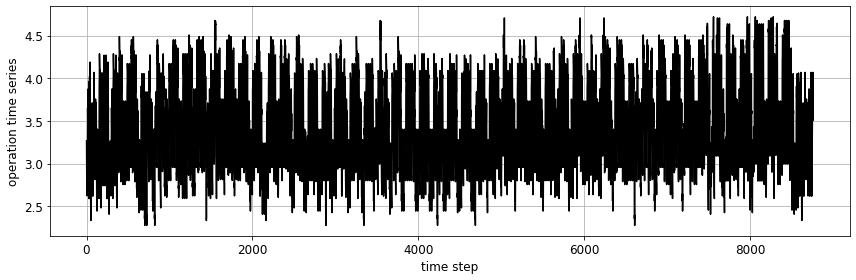

In [15]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'GermanyRegion')

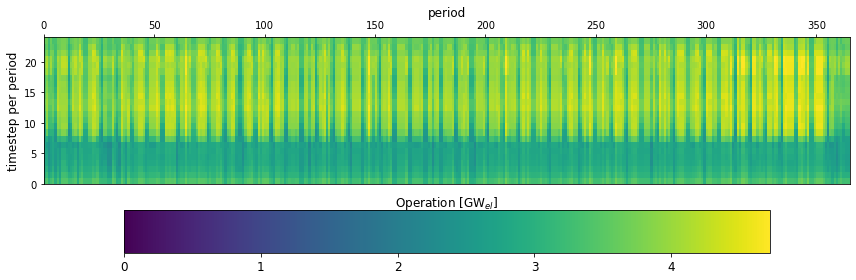

In [16]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'GermanyRegion')

### Conversion

Show optimization summary

In [17]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

GermanyRegion
Component                  Property  Unit                         
Electroylzers              TAC       [1e9 Euro/a]         0.354699
                           capacity  [GW$_{el}$]           4.07631
                           capexCap  [1e9 Euro/a]         0.303745
                           invest    [1e9 Euro]            2.03816
                           operation [GW$_{el}$*h/a]       15353.3
                           opexCap   [1e9 Euro/a]        0.0509539
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]         0.126157
                           capacity  [GW$_{el}$]           1.54233
                           capexCap  [1e9 Euro/a]        0.0937679
                           invest    [1e9 Euro]            1.07963
                           operation [GW$_{el}$*h/a]       3589.34
                           opexCap   [1e9 Euro/a]         0.032389

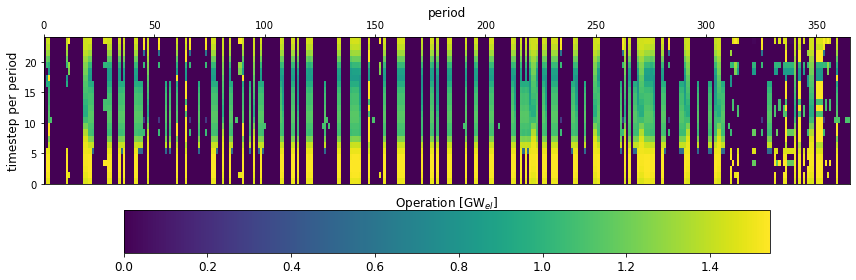

In [18]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (hydrogen)', 'GermanyRegion')

### Storage

Show optimization summary

In [19]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

GermanyRegion
Component               Property           Unit                                
Li-ion batteries        TAC                [1e9 Euro/a]                 2.68739
                        capacity           [GW$_{el}$*h]                159.937
                        capexCap           [1e9 Euro/a]                 2.36752
                        invest             [1e9 Euro]                   24.1504
                        operationCharge    [GW$_{el}$*h/a]              7371.12
                        operationDischarge [GW$_{el}$*h/a]              6623.48
                        opexCap            [1e9 Euro/a]                0.319873
Salt caverns (hydrogen) TAC                [1e9 Euro/a]                0.716143
                        capacity           [GW$_{H_{2},LHV}$*h]         1235.22
                        capexCap           [1e9 Euro/a]               0.0120693
                        invest             [1e9 Euro]                  0.135874
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]       10243.7
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]       10243.7
                        opexCap            [1e9 Euro/a]                0.704073

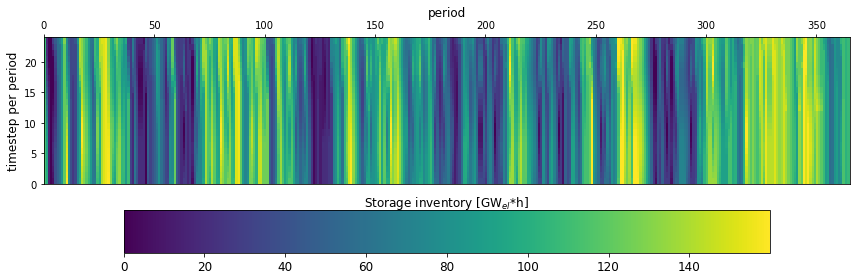

In [20]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'GermanyRegion', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

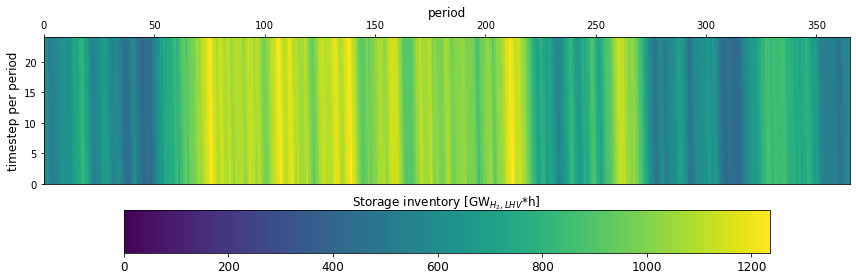

In [21]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'GermanyRegion',
                                  variableName='stateOfChargeOperationVariablesOptimum')